#### based on: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb
#### https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Define Function

In [ ]:
def f(x):
    return 3*(x**2) - 4*x + 5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

### Derivatives

#### Definition:
$$ L = \lim_{h \to 0} = {f(a + h) - f(a) \over{h}}

In [ ]:
h = 0.00000001
x = 3
print(f(x + h))

In [ ]:
print((f(x + h) - f(x)) / h)
# by hand:
# Function: 3*(x**2) - 4*x + 5
# Derivative: 3*2*x - 4 + 0 = 6*x - 4
# Plugging in 3.0: 6*3 - 4 = 14

### More complex function
#### Derivative with respect to a, b, and c

In [ ]:
h = 0.00000000000001

a = 2.0
b = -3.0
c = 10.0

d = a*b + c

print(d)

d1 = a*b + c
a += h
d2 = a*b + c 
print(f'd1', d1)
print(f'd2', d2)
print(f'Slope', (d2-d1)/h)

In [ ]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

print(d)

d1 = a*b + c
b += h
d2 = a*b + c 
print(f'd1', d1)
print(f'd2', d2)
print(f'Slope', (d2-d1)/h)

In [ ]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

print(d)

d1 = a*b + c
c += h
d2 = a*b + c 
print(f'd1', d1)
print(f'd2', d2)
print(f'Slope', (d2-d1)/h)

### Getting to Neural Networks

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        return out
    

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b + c
d

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ data %.4f }" % (n.data, ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
draw_dot(d)

### Building further

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        return out
    

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')

L = d * f; L.label = 'L'

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data, ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
draw_dot(L)

### In Neuronal Networks we want Backpropagation
#### We want to calculate the gradiate along all these intermediate values (derivative from L with repsect to L, L with respect to f, L with respect to d, ...)

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # Gradient is initially zero
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        return out
    

In [4]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')

L = d * f; L.label = 'L'

draw_dot(L)

In [ ]:
# Derivative of L with respect to L
def lol():
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data + h
    
    print((L2 - L1)/h)

lol()

# Derivative of L with respect to a

def lol2():
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data 
    
    print((L2 - L1)/h)

lol2()

#### filling in derivative of L with respect to L (=1)

In [ ]:
L.grad = 1.0
draw_dot(L)

#### Derivative of L with respect to d

In [ ]:
# L = d * f
# dL/dd = 1 * f
# (f(x+h)-f(x)) / h
# ((d+h)*f - d*f) / h
# d*f + hf - df
# hf/f
# f

d.grad = -2.0

# L = d * f
# dL/dd = 1 * d

f.grad = d.data

In [ ]:
# dL/dc

# Chain Rule
# dz/dx = dy/dx * dz/dy 

# we know: dz/dy = dL/dd = -2.0
# we need: dd/dc 

# d = c + e
# dd/dc = 1
# dd/de = 1

# Derivative of L with respect to L
def lol():
    h = 0.00001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    e.data = e.data + h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data 
    
    print((L2 - L1)/h)

lol()

c.grad = -2.0
e.grad = -2.0


In [ ]:
# dL/da
# Chain Rule:
# dz/dx = dz/dy * dy/dx
# -2 * dy/dx
# dy/dx
# e = a*b
# de/da = b
# de/db = a

# Chain Rule: -2a and -2b
a.grad = -2.0 * b.data
b.grad = -2.0 * a.data
draw_dot(L)

### Now Backpropagation and Feed forward to get L closer to 0 (e.g. the loss)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')

L = d * f; L.label = 'L'

a.grad = -2.0 * b.data
b.grad = -2.0 * a.data
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = d.data
L.grad = 1.0
draw_dot(L)



In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Feedforward

e = a * b
d = e + c 
L = d * f
print(L)

In [ ]:
for _ in range(20):
    # Backpropagation
    a.data += 0.01 * a.grad
    b.data += 0.01 * b.grad
    c.data += 0.01 * c.grad
    f.data += 0.01 * f.grad

    # Feedforward

    e = a * b
    d = e + c 
    L = d * f
    print(L)

# Backpropagation through a Neuron
## slightly more complex example

#### Input x with weights w (multiplication) -> cell body
#### cell body + bias
#### function(cell body + bias) where the function is a squashing function like sigmoid or tanh etc.

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [ ]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# cell body (without activation function)
n = x1w1x2w2 + b; n.label='n'

draw_dot(n)

In [ ]:
# we need to implement tanh
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # Gradient is initially zero
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        return out
    
    def tanh(self):
        a = 1 - (2 / (math.exp(2*self.data) + 1))
        out = Value(a, (self, ), 'tanh')
        return out
        #x = self.data
        #t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        #out = Value(t, (self,), 'tanh')
        #return out

In [ ]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# cell body (without activation function)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

draw_dot(o)

In [ ]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# cell body (without activation function)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'



In [ ]:
# Finding the derivatives

# do/do = 1
o.grad = 1.0

# do/dn = 1- tanh(x)**2
# =1 - x**2
n.grad = 1 - (o.data**2)

# x1w1x2w2 and b are additive. so the derivative is the same as in n
x1w1x2w2.grad = n.grad
b.grad = n.grad

# same holds for x1 w1 and x2w2
x1w1.grad = n.grad
x2w2.grad = n.grad

# do/dw1: 
# dz/dx = dy/dx * dz/dy 
# dz/dy = 0.5
# x1w1 = w1 * x1
# dy/dx1 = w1 
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
type(o.grad)

In [ ]:
draw_dot(o)

# Resetting Values

In [ ]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# cell body (without activation function)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [ ]:
draw_dot(o)

# Extending the backward pass

In [ ]:
# we need to implement tanh
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # Gradient is initially zero
        self._backward = lambda: None # NEW: empty function
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward(): # NEW: define what happens: Chain rule
            self.grad = 1.0 * out.grad # why is this working. Where is out.grad coming from?
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward(): # NEW: Chain rule
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        a = 1 - (2 / (math.exp(2*self.data) + 1))
        out = Value(a, (self, ), 'tanh')
        
        def _backward():
            self.grad = 1 - (a**2) * out.grad
            
        out._backward = _backward
        return out
        #x = self.data
        #t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        #out = Value(t, (self,), 'tanh')
        #return out

In [ ]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# cell body (without activation function)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1
o._backward()

n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

# Topological Graph so Functions get called in the correct order

In [ ]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# cell body (without activation function)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [ ]:
topo = []

visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            #print(child)
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

In [ ]:
o.grad= 1
for node in reversed(topo):
    node._backward()

In [ ]:
draw_dot(o)

# Put it in the Value class

In [34]:
# we need to implement tanh
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # Gradient is initially zero
        self._backward = lambda: None # NEW: empty function
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward(): # NEW: define what happens: Chain rule
            self.grad = 1.0 * out.grad # why is this working. Where is out.grad coming from? added += because other wise functions that recall objects multiple times wouldn't work. The gradients would be overwritten instead of added
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward(): # NEW: Chain rule
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        t = 1 - (2 / (math.exp(2*self.data) + 1))
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = 1 - (t**2) * out.grad
            
        out._backward = _backward
        return out
        #x = self.data
        #t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        #out = Value(t, (self,), 'tanh')
        #return out
        
            
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
        


In [35]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

# cell body (without activation function)
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

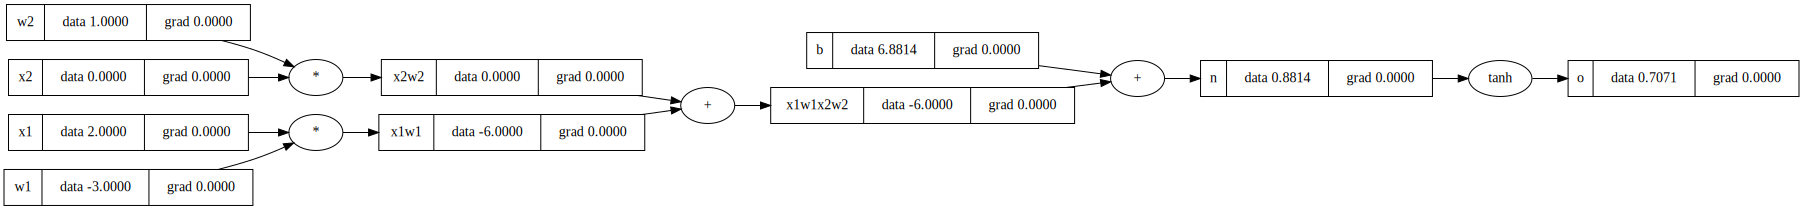

In [36]:
draw_dot(o)

In [37]:
o.backward()

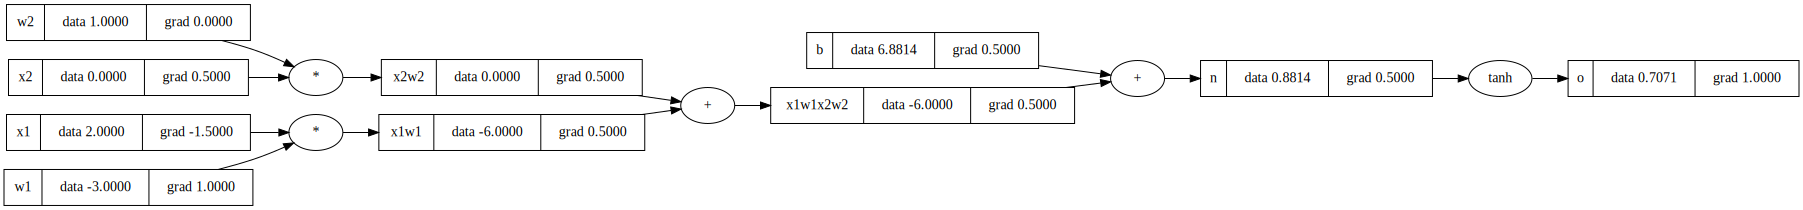

In [38]:
draw_dot(o)

# One Problem

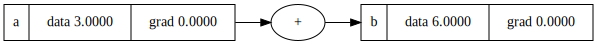

In [39]:
a = Value(3.0, label='a')
b = a + a; b.label='b'

draw_dot(b)

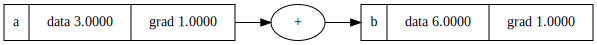

In [40]:
b.backward()

draw_dot(b)

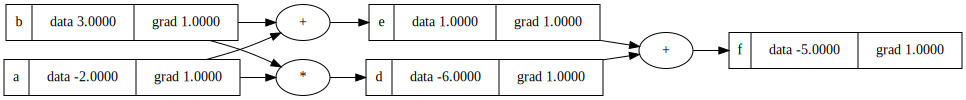

In [41]:
a = Value(-2.0, label='a')
b = Value(3.0 , label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d+e; f.label='f'

f.backward()
draw_dot(f)